## DATA MINING PROJECT
# ABCDEats Inc\. Final Report

**Group 20** <br>
Afonso Gamito, 20240752 <br>
Gonçalo Pacheco, 20240695 <br>
Hassan Bhatti, 20241023 <br>
Moeko Mitani, 20240670

# Import the Libraries and CVS file

In [1]:
import pandas as pd
import sqlite3
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from math import ceil
from sklearn.base import clone
from itertools import product
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

sns.set()
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import CVS file
file_path = 'project_data/preprocessed_dataset.csv'
df = pd.read_csv(file_path)

FileNotFoundError: [Errno 2] No such file or directory: 'project_data/preprocessed_dataset.csv'

# 13. Hierarchical Clustering

In [253]:
from sklearn.cluster import AgglomerativeClustering

# Performing HC
hclust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(scaled_data[metric_features]) # CODE HERE
hc_labels

array([4, 2, 2, ..., 4, 4, 2])

In [254]:
# Characterizing the clusters

labels_series = pd.Series(hc_labels, 
                          name='labels', 
                          index=df.index 
                          ) 

df_concat = pd.concat([scaled_data, labels_series],axis=1)

df_concat[metric_features+['labels']].groupby('labels').mean()

,vendor_count,days_as_client,money_spent,total_orders,average_purchase,evening_orders
labels,,,,,,
0.0,0.114084,0.798266,0.050952,0.087414,0.082494,0.036877
1.0,0.057918,0.519883,0.027638,0.037326,0.091816,0.017638
2.0,0.023151,0.134834,0.015847,0.013573,0.103737,0.008335
3.0,0.039014,0.328321,0.020731,0.023983,0.094465,0.012641
4.0,0.019992,0.106763,0.015347,0.011801,0.108311,0.007287


### Defining the number of clusters:

In [258]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'


hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(scaled_data[metric_features])

array([22841, 27548, 19651, ...,     1,     2,     0])

In [260]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)



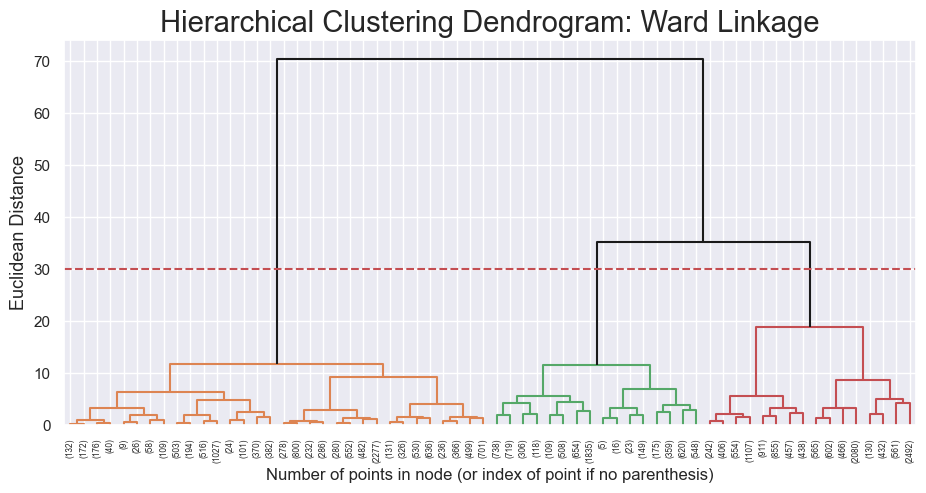

In [266]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 30
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

### Test cluster solutions

In [269]:
# 2 cluster solution
n_clusters = 2

hc2_clust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)
hc2_labels = hc2_clust.fit_predict(scaled_data[metric_features])

In [270]:
# Characterizing the 2 clusters
df_concat = pd.concat([scaled_data[metric_features], 
                       pd.Series(hc2_labels, 
                                 name='labels', 
                                 index=df.index)], 
                    axis=1)

df_concat.groupby('labels').mean()

,vendor_count,days_as_client,money_spent,total_orders,average_purchase,evening_orders
labels,,,,,,
0.0,0.073173,0.570132,0.034214,0.051841,0.089158,0.023246
1.0,0.022182,0.126224,0.015694,0.013029,0.105140,0.008013


In [279]:
# 3 cluster solution
n_clusters = 3

hc3_clust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)
hc3_labels = hc3_clust.fit_predict(scaled_data[metric_features])

In [280]:
# Characterizing the 3 clusters
df_concat = pd.concat([scaled_data[metric_features], 
                       pd.Series(hc3_labels, 
                                 name='labels', 
                                 index=df.index)], 
                    axis=1)

df_concat.groupby('labels').mean()

,vendor_count,days_as_client,money_spent,total_orders,average_purchase,evening_orders
labels,,,,,,
0.0,0.050279,0.442467,0.024847,0.031934,0.092887,0.015619
1.0,0.022182,0.126224,0.015694,0.013029,0.105140,0.008013
2.0,0.114084,0.798266,0.050952,0.087414,0.082494,0.036877


In [281]:
## See crosstab of 2 vs 3
## What does this mean?

pd.crosstab(
    pd.Series(hc3_labels, name='hc3_labels', index=df.index),
    pd.Series(hc2_labels, name='hc2_labels', index=df.index),
    )

hc2_labels,0,1
hc3_labels,,
0,12298,0
1,0,12451
2,6882,0


### Final Hierarchical clustering solution

In [289]:
# final cluster solution
linkage = "ward"
distance = "euclidean"
n_clusters = 3

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels = hclust.fit_predict(scaled_data[metric_features])

In [290]:
# Characterizing the final clusters

df_concat = pd.concat([
    scaled_data[metric_features], 
    pd.Series(hc_labels, name='labels', index=df.index)
    ], 
    axis=1)
df_concat.groupby('labels').mean()

,vendor_count,days_as_client,money_spent,total_orders,average_purchase,evening_orders
labels,,,,,,
0.0,0.050279,0.442467,0.024847,0.031934,0.092887,0.015619
1.0,0.022182,0.126224,0.015694,0.013029,0.105140,0.008013
2.0,0.114084,0.798266,0.050952,0.087414,0.082494,0.036877


# 14. K-Means Clustering

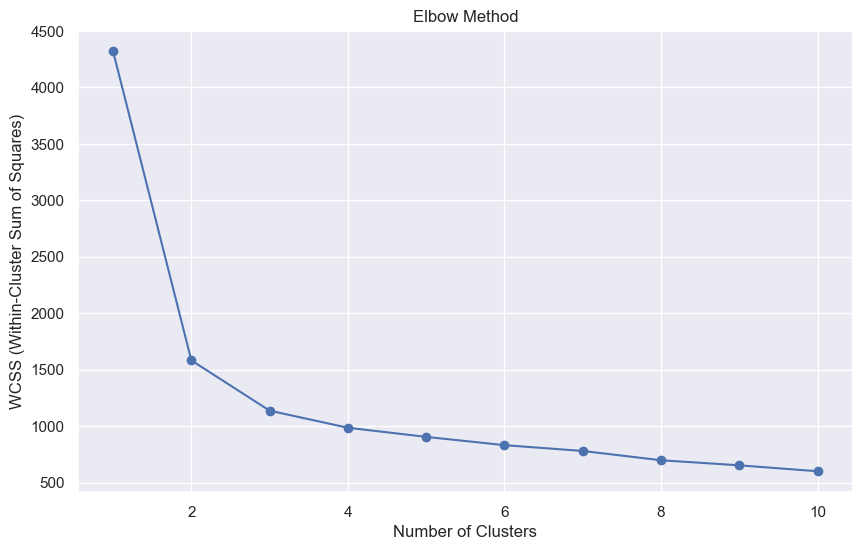

In [133]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate WCSS for different numbers of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(cleaned_data)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

# 14. Clustering by perspectives

In [222]:
Customer_Profile = [
    'customer_age',
    'days_as_client',
    'average_purchase',
    'evening_orders',
    'night_orders'
]

Transaction_Patterns = [
    'total_orders',
    'money_spent',
    'vendor_count'
]

df_customer = cleaned_data[Customer_Profile].copy()
df_transactions = cleaned_data[Transaction_Patterns].copy()

## Testing on K-means clustering
Based on the elbow method, the optimal number of clusters is between 2 and 3.

In [225]:
# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

### Finding the optimal clusterer on Customer_Profile variables